In [18]:
# Imports
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib/python')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs
from ncbi_remap.io import add_table

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_qc')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../../sra.h5')

last updated: 2017-11-03 
Git hash: 658176c5bd52d20a209ce689557b33c7f562447e


In [77]:
# Constants
from ncbi_remap.prealn_wf import LIBSIZE_CUTOFF, READLEN_CUTOFF, STRAND_CUTOFF1, \
    STRAND_CUTOFF2, UNALIGN_CUTOFF, CONTAMINATION_CUTOFF

REFERENCES = [
    'adapters', 
    'phix', 
    'ercc', 
    'dm6', 
    'wolbachia', 
    'yeast', 
    'ecoli', 
    'hg19',
]

num_samples = store['prealn/complete'].shape[0]

# Quality Control

The first step in the pre-alignment workflow is to determine run quality. Run quality is highly variable. SRA accepts any type of sequencing data, here I focus on high throughput sequencing experiments and may identify lower throughput methods as low quality. Sequencing quality has improved over the last 10 years, so older experiments may also fail quality filters. It is also possible that author's or sequencing centers may include lower quality datasets for completeness.

## Library Size

Over the past decade, sequencing technologies increased library sizes dramatically. Here we focus on high throughput sequencing by focusing on libraries that have at least {{'{:,.0f}'.format(LIBSIZE_CUTOFF)}} reads. 

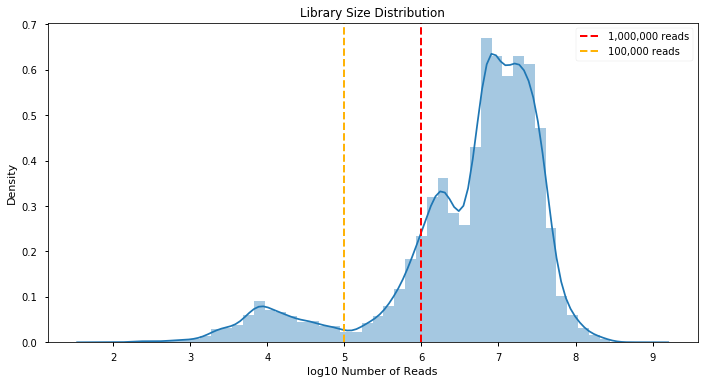

In [64]:
# Plot distribution of libsizes
@make_figs(nbconfig.fig_name('distplot_libsize'), 
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['srx', 'srr', 'libsize_R1']]
    fig, ax = plt.subplots(1, 1)
    sns.distplot(np.log10(df.libsize_R1), ax=ax)
    ax.axvline(np.log10(1e6), ls='--', lw=2, color='r', label='1,000,000 reads')
    ax.axvline(np.log10(1e5), ls='--', lw=2, color=sns.xkcd_rgb['amber'], label='100,000 reads')
    ax.legend()
    ax.set_xlabel('log10 Number of Reads')
    ax.set_ylabel('Density')
    ax.set_title('Library Size Distribution');
    return fig

plot(store)

In [66]:
# Make flags
from ncbi_remap.prealn_wf import libsize, libsize_cnts
libsize_ok = libsize(store, cutoff=LIBSIZE_CUTOFF)
libsize_million = libsize(store, cutoff=1e6)

# Summary
n_samples = '{:,}'.format(num_samples)
n_gt_million = '{:,}'.format(libsize_million.shape[0])
n_gt_ok = '{:,}'.format(libsize_ok.shape[0])
cutoff = '{:,.0f}'.format(LIBSIZE_CUTOFF)
lmin, lmed, lmax = ['{:,.0f}'.format(x) for x in libsize_cnts(store)]

Of the {{n_samples}} runs, {{n_gt_million}} runs have more than 1 million reads. For the remainder of this project we will focus on the {{n_gt_ok}} runs that have ≥{{cutoff}} reads.

### Criteria
* Library Size ≥{{cutoff}} reads

### Summary

Library Size | Number of Reads
------------ | ---------------
Min | {{lmin}}
Median | {{lmed}}
Max | {{lmax}}
**Runs ≥{{cutoff}}** | {{n_gt_ok}} (SRRs)

## Read Length

Similar to library size, read lengths have also drastically increased over the past decade. Focusing on Illumina sequencing technologies, initial read lengths were ~30 bp longs, recent advancements have made read lengths over 150 bp possible.

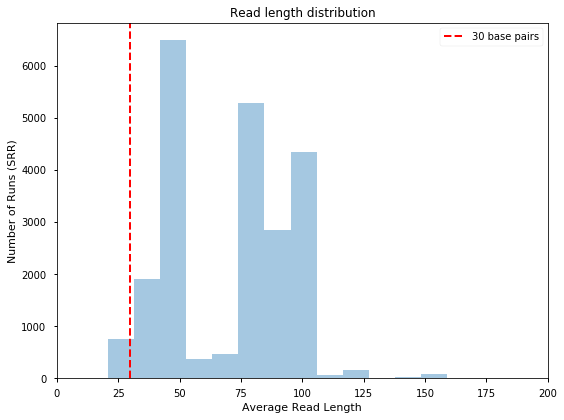

In [68]:
# Plot distirubtion of read lengths
@make_figs(nbconfig.fig_name('distplot_readLen'), 
           styles=nbconfig.styles, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['srx', 'srr', 'avgLen_R1', 'avgLen_R2']]
    df['len'] = df[['avgLen_R1', 'avgLen_R2']].max(axis=1)

    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.len, bins=100, ax=ax, kde=False)
    ax.set_xlabel('Average Read Length')
    ax.set_ylabel('Number of Runs (SRR)')
    ax.set_xlim(0, 200)
    ax.set_title('Read length distribution');
    ax.axvline(READLEN_CUTOFF, ls='--', lw=2, color='r', label='{} base pairs'.format(READLEN_CUTOFF))
    ax.legend()
    
    return fig

plot(store)

In [69]:
# Make flags
from ncbi_remap.prealn_wf import readlen, readlen_cnts
readlen_ok = readlen(store, cutoff=READLEN_CUTOFF)
readlen_gt_200 = readlen(store, cutoff=200)

# Summary
cutoff = '{:.0f}'.format(READLEN_CUTOFF)
n_gt_cutoff = '{:,}'.format(readlen_ok.shape[0])
n_gt_200 = '{:,}'.format(readlen_gt_200.shape[0])

lmin, lmed, lmax = ['{:,.0f}'.format(x) for x in readlen_cnts(store)]

Here we look at the average read length for each run. There are {{n_gt_cutoff}} runs that have an average read length ≥{{cutoff}} bp. The most popular read length is 50 bp (>6,000 runs), followed by 75 bp with more than 5,000 runs. There are {{n_gt_200}} runs with a read length ≥200 bp.

### Criteria
* ≥{{cutoff}} bp

### Summary

Avg Read Length | Read Length
--------------- | --------------
Min | {{lmin}}
Median | {{lmed}}
Max | {{lmax}}
**Runs ≥{{cutoff}} bp** | {{n_gt_cutoff}} (SRRs)

## Stranded

While not strictly a quality control metric, library strandedness is an important metric to decide which runs are useful for different purposes (e.g., annotation or splicing). Strandedness is determined by the library chemistry, with the majority of samples likely to be from unstranded protocols followed by the second stranded (Illumina's stranded protocol). If a stranded protocol was attempted, incomplete strandedness could indicate potential problems during library preparation. Strandedness is important during the alignment procedure. Many aligners including hisat2 use strand information to improve alignment. To determine strandedness, reads were aligned in unstranded mode with hisat2. Alignments were then processed with Picard's CollectRNASeqMetrics using three separate modes (First stranded, Second stranded, Unstranded). In First stranded mode, reads are expected to map to the same strand as the gene model. In Second stranded mode, reads are expected to map to the opposite strand as the gene model. In unstranded mode reads are expected to map irrespective of the strand the gene model is on. Picard reports the proportion of reads that map to the "correct" strand. 

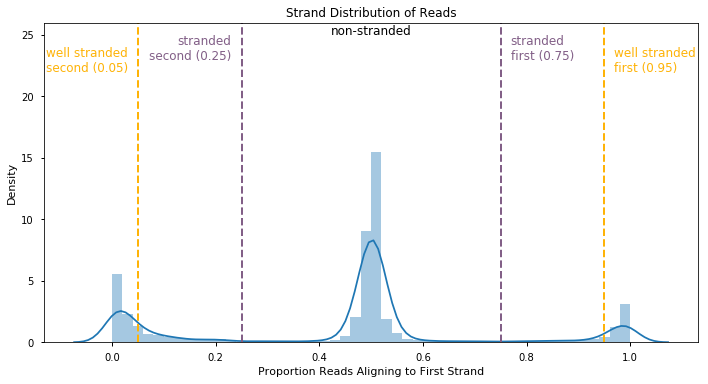

In [70]:
# Plot distribution of strandedness
@make_figs(nbconfig.fig_name('distplot_strandedness'), styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/collectrnaseqmetrics/first']
    c1 = sns.xkcd_rgb['dusty purple']
    c2 = sns.xkcd_rgb['amber']
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.PCT_CORRECT_STRAND_READS, ax=ax)
    ax.set_title('Strand Distribution of Reads')
    ax.set_xlabel('Proportion Reads Aligning to First Strand')
    ax.set_ylabel('Density')
    ax.axvline(STRAND_CUTOFF1, ls='--', lw=2, color=c1)
    ax.axvline(1 - STRAND_CUTOFF1, ls='--', lw=2, color=c1)
    ax.axvline(STRAND_CUTOFF2, ls='--', lw=2, color=c2)
    ax.axvline(1 - STRAND_CUTOFF2, ls='--', lw=2, color=c2)

    _ct1 = STRAND_CUTOFF1
    _ct2 = 1 - STRAND_CUTOFF1
    ax.annotate(xy=(_ct1, 23), s='stranded\nfirst ({:.2f})'.format(_ct1), xytext=(10, 0), textcoords='offset points', color=c1)
    ax.annotate(xy=(_ct2, 23), s='stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-10, 0), textcoords='offset points', color=c1)

    _ct1 = STRAND_CUTOFF2
    _ct2 = 1 - STRAND_CUTOFF2
    ax.annotate(xy=(_ct1, 22), s='well stranded\nfirst ({:.2f})'.format(_ct1), xytext=(10, 0), textcoords='offset points', color=c2)
    ax.annotate(xy=(_ct2, 22), s='well stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-10, 0), textcoords='offset points', color=c2)

    ax.annotate(xy=(.5, 25), s='non-stranded', ha='center', color='k')
    ax.set_ylim(0, 26)
    return fig

plot(store)

In [71]:
# Make flags
from ncbi_remap.prealn_wf import strandedness

def pout(c, f, s, u):
    print("""\
    Cutoff: {:0.2f}
    First Strand: {:,}
    Second Strand: {:,}
    Unstranded: {:,}
    """.format(c, f.shape[0], s.shape[0], u.shape[0]))

f1, s1, u1 = strandedness(store, cutoff=STRAND_CUTOFF1)
f2, s2, u2 = strandedness(store, cutoff=STRAND_CUTOFF2)


# Summary
cutoff1 = '{:.2f}'.format(STRAND_CUTOFF1)
cutoff2 = '{:.2f}'.format(STRAND_CUTOFF2)

n_f_cutoff1 = '{:,}'.format(f1.shape[0])
n_s_cutoff1 = '{:,}'.format(s1.shape[0])
n_u_cutoff1 = '{:,}'.format(u1.shape[0])

n_f_cutoff2 = '{:,}'.format(f2.shape[0])
n_s_cutoff2 = '{:,}'.format(s2.shape[0])
n_u_cutoff2 = '{:,}'.format(u2.shape[0])

Above we plot Picard's output of the proportion of reads aligning to correct strand (PCT_CORRECT_STRAND_READS) for the First strand mode. Unstranded runs will have approximately 50% of reads mapping to the first strand. First stranded runs will have the majority of reads mapping to the correct strand. Second stranded runs will have few reads mapping to the first strand. Here we selected two cutoffs ({{cutoff1}}, {{cutoff2}}). For setting alignment criteria we used less stringent {{cutoff1}}. While {{cutoff2}} are well stranded runs that would be more appropriate for looking annotations. 

### Criteria
* ≥{{cutoff1}} reads correct strand
* ≥{{cutoff2}} reads correct strand

### Summary

**≥{{cutoff1}} reads correct strand**

Strandedness | Number of Runs
------------ | --------------
First Strand | {{n_f_cutoff1}}
Second Strand | {{n_s_cutoff1}}
Unstranded | {{n_u_cutoff1}}


**≥{{cutoff2}} reads correct strand**

Strandedness | Number of Runs
------------ | --------------
First Strand | {{n_f_cutoff2}}
Second Strand | {{n_s_cutoff2}}
Unstranded | {{n_u_cutoff2}}



## Mapability

Perhaps the most important quality metric is how well reads align to the genome. Here we look at overall mapability. Independent of the library strategy, we may expect that the majority of reads should map to the reference genome. A large fraction of unaligned reads tends to indicate either issues with library construction or incorrect metadata. There are known instances where libraries were constructed by mixing multiple species, but these are rare and in our experience species specific reads are separated prior to upload. Therefore we look to exclude runs that have excessive amounts of unaligned reads.

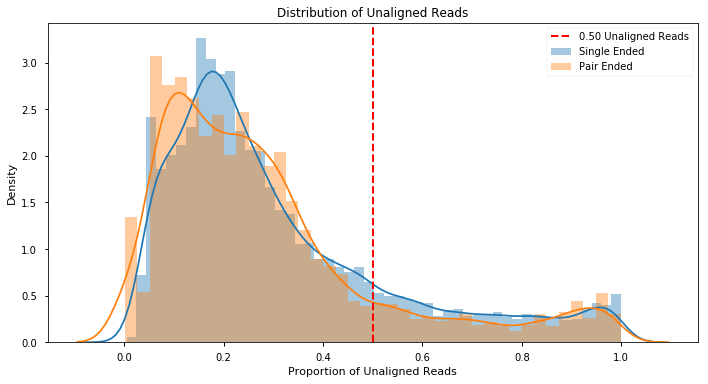

In [79]:
# Plot distribution of unmapped reads.
@make_figs(nbconfig.fig_name('distplot_unaligned'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    se = store['prealn/workflow/hisat2/SE'][['srx', 'srr', 'num_reads', 'num_unaligned']]
    se['prop_unaligned'] = se['num_unaligned'] / se['num_reads']

    pe = store['prealn/workflow/hisat2/PE'][['srx', 'srr', 'num_reads', 'num_concordant_reads_unaligned']]
    pe['prop_unaligned'] = pe['num_concordant_reads_unaligned'] / pe['num_reads']

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.prop_unaligned, ax=ax, label='Single Ended')
    sns.distplot(pe.prop_unaligned, ax=ax, label='Pair Ended')
    ax.axvline(UNALIGN_CUTOFF, color='r', ls='--', lw=2, label='{:0.2f} Unaligned Reads'.format(UNALIGN_CUTOFF))
    ax.legend()
    ax.set_title('Distribution of Unaligned Reads')
    ax.set_xlabel('Proportion of Unaligned Reads')
    ax.set_ylabel('Density');
    
plot(store)

In [87]:
# Make flags
from ncbi_remap.prealn_wf import mappability
mapping_ok = mappability(store, cutoff=UNALIGN_CUTOFF)

# Summary
cutoff = '{:.0f}'.format(UNALIGN_CUTOFF * 100)
n_lt_cutoff = '{:,.0f}'.format(mapping_ok.shape[0])

The majority of runs (n={{n_lt_cutoff}}) had fewer than {{cutoff}}% unaligned reads. Single-End and Pair-End runs show similar distributions of  unaligned reads. 

## Contamination

I am worried about several potential forms of contamination. First I am worried that submitters may have misidentified their submission as D. melanogaster. Second I want to identify samples that have specific contaminations from other species, which could be caused by actual sample contamination or because samples were mixed with another species as a form of multiplexing. Finally, this metric can identify large fractions of reads aligning to rRNA which could indicate a failed poly(A) selection or ribo subtraction, or possibly that the library was constructed in some non-standard way.

Fastq Screen was used to look for sources of contamination. Here I aligned untrimmed FASTQs to different reverences. References were technical (Adapters, ERCC, PhiX) and biological (dm6, dm6-rRNA, ecoli, hg19, wolbachia, yeast) in nature. Fastq screen summarizes reads into different classes based on if reads align to a single or multiple locations within a references and if they align to a single or multiple references. Different classes of counts can be used to look for different types of problems. For example, a sample with a high percentage of "one hit one library" aligning to hg19 would indicate that the sample was either human in nature or mixed with human samples. Similarly, looking at "multiple hit multiple libraries" reads that also align to rRNA can be used to identify rRNA contamination.

### One Hit One Library (Contamination)

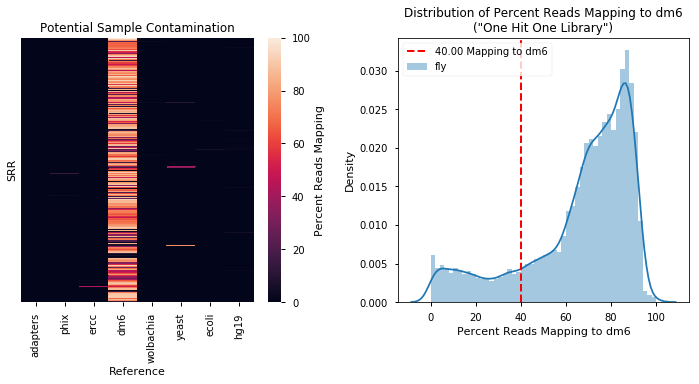

In [11]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('heatmap_distplot_contamination'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen']
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.heatmap(df[REFERENCES], yticklabels=False, cbar_kws={'label': 'Percent Reads Mapping'}, ax=ax1)
    ax1.set_title('Potential Sample Contamination');
    ax1.set_ylabel('SRR');
    ax1.set_xlabel('Reference');

    # Plot distirbution of major categories
    sns.distplot(df.dm6, label='fly', ax=ax2)
    plt.title('Distribution of Percent Reads Mapping to dm6\n("One Hit One Library")');
    ax2.set_xlabel('Percent Reads Mapping to dm6')
    ax2.set_ylabel('Density')
    ax2.axvline(CONTAMINATION_CUTOFF, color='r', ls='--', lw=2, 
                label='{:0.2f} Mapping to dm6'.format(CONTAMINATION_CUTOFF))
    ax2.legend()
    
    return fig

plot(store)

In [12]:
# Create summary table showing the number of samples whose majority of 
# reads came from a specific reference.
def summary(store):
    df = store['prealn/workflow/fastq_screen']
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)

    table = df.apply(lambda x: x.argmax(), axis=1).value_counts()
    table['total'] = table.sum()
    table = table.map(lambda x: '{:,}'.format(x)).to_frame()

    table.columns = ['Number of Samples']
    
    return table

summary(store)

,Number of Samples
dm6,"22,596"
yeast,204
hg19,50
ercc,36
adapters,17
phix,11
rRNA,11
ecoli,9
wolbachia,4
total,"22,938"


In [13]:
# Make flags
from ncbi_remap.prealn_wf import contamination
contamination_ok = contamination(store, cutoff=CONTAMINATION_CUTOFF)
print('There are {:,} samples with ≥{:0.0f}% '
      'reads mapping to D. melanogaster.'.format(
          contamination_ok.shape[0], CONTAMINATION_CUTOFF
      )
)

There are 19,392 samples with ≥40% reads mapping to D. melanogaster.


### rRNA Over-representation

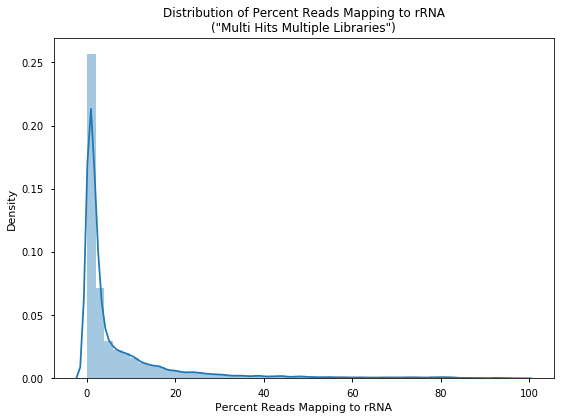

In [14]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('distplot_rRNA_overrep'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen']
    df = df[['srx', 'srr', 'reference', 'multiple_hits_multiple_libraries_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.rRNA, ax=ax)
    ax.set_title('Distribution of Percent Reads Mapping to rRNA\n("Multi Hits Multiple Libraries")');
    ax.set_xlabel('Percent Reads Mapping to rRNA')
    ax.set_ylabel('Density')
    
    return fig

plot(store)

## QC Flags

In [20]:
ok_samples = libsize_ok.merge(
    readlen_ok, on=['srx', 'srr'], how='inner').merge(
    mapping_ok, on=['srx', 'srr'], how='inner').merge(
    contamination_ok, on=['srx', 'srr'], how='inner')

add_table(store, 'prealn/qc_passed', data=ok_samples, force=True)
print('There are {:,} samples that pass all set criteria.'.format(ok_samples.shape[0]))

There are 17,140 samples that pass all set criteria.
